In [1]:
import numpy as np
import pandas as pd
from os import path
import matplotlib.pylab as plt

from dual_controller_model_figures.plot import plot_functions as pf

In [2]:
repo_path = path.abspath('.')

# output path for the plots
out_path = path.join(repo_path, 'output_plots')

# read the data
dual_model_file = path.join(repo_path, 'data/Intact_reward_100trails_1000timesteps.csv')
rpe_model_file = path.join(repo_path, 'data/NoTail_reward_100trails_1000timesteps.csv')
ape_model_file = path.join(repo_path, 'data/NoDorsal_reward_100trails_1000timesteps.csv')

dual_model = pd.read_csv(dual_model_file, header=None).to_numpy()
rpe_model = pd.read_csv(rpe_model_file, header=None).to_numpy()
ape_model = pd.read_csv(ape_model_file, header=None).to_numpy()

No handles with labels found to put in legend.


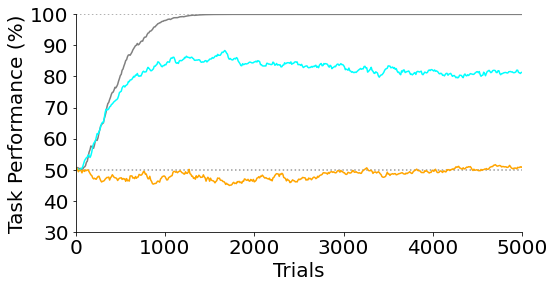

In [3]:
# create a publication-quality figure, grouping the data by the Experimental Group,
# and showing the continous monitoring of learning

fig1 = pf.make_figure_learning_across_trials(dual_model, rpe_model, ape_model)
fig1.show()

plt.savefig(path.join(out_path, 'Performance_between_groups.pdf'),
            transparent=True, bbox_inches='tight')

In [ ]:
dms = dual_model.copy()
rms = rpe_model.copy()
for i in range(50):
    np.random.shuffle(dms)
    np.random.shuffle(rms)
    plt.plot(xs, np.mean(dms[0:10, ], axis=0), color='blue', alpha=.1)
    plt.plot(xs, np.mean(rms[0:10, ], axis=0), color='orange', alpha=.1)

# %%
for i in range(dual_model.shape[0]):
    plt.plot(xs, rpe_model[i,], color='k', alpha = .02)

In [ ]:
# optional: subselect X agents to match experimental
n_agents = 10
np.random.shuffle(dms)
dms = dms[0:n_agents, ]
np.random.shuffle(rms)
dms = dms[0:n_agents, ]


In [ ]:
# %%
# plot differences
model_diffs = 100 * (np.mean(dms, axis=0) - np.mean(rms, axis=0))
plt.plot(xs, model_diffs)
# CAUTION: there are some weird regularities here!

In [ ]:
plt.plot(xs, np.mean(dms, axis=0))
plt.plot(xs, np.mean(rms, axis=0))

In [ ]:
# create shuffles of the data and calculate the
# differences of the means. Create a shuffled array of means
n_times = 1000
rows, cols = dms.shape
shuffled_arr = np.empty([n_times, cols])
# mix both models
mixed = np.concatenate([dms, rms])
for i in range(n_times):
    # shuffle and split in half
    np.random.shuffle(mixed)
    mean1 = np.mean(mixed[0:rows, ], axis=0)
    mean2 = np.mean(mixed[rows:, ], axis=0)
    shuffled_arr[i, :] = 100 * (mean1 - mean2)

In [ ]:
# calculate confidence intervals
top_ci = np.quantile(shuffled_arr, .95, axis=0)
bot_ci = np.quantile(shuffled_arr, .05, axis=0)

In [ ]:
# plot
fig2 = plt.figure(figsize=(8, 4))
plt.axhline(0, ls='dotted', alpha=0.4, color='k')
plt.plot(xs, model_diffs, color='k', label='observed data')
plt.plot(xs, top_ci, linestyle='--', color='gray', label='95% ci')
plt.plot(xs, bot_ci, linestyle='--', color='gray')
plt.fill_between(xs, top_ci, model_diffs, where=model_diffs >= top_ci,
                 facecolor='k', alpha=.2, interpolate=True)
plt.ylabel('performance difference (%)')
plt.xlabel('trial number')
plt.legend(loc=(0.75, 0.05), frameon=False)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim((0,5000))

plt.savefig(path.join(out_path, 'Differences_of_means_significance.pdf')
            ,transparent=True, bbox_inches='tight')
fig2.show()